In [3]:
pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import chess
import chess.engine
# import chess.svg

# Set up chess board

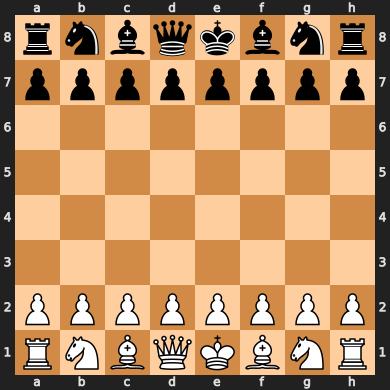

In [6]:
board = chess.Board()

# chess.svg.board(board, size=500)
board

## See legal moves

In [9]:
board.reset_board()

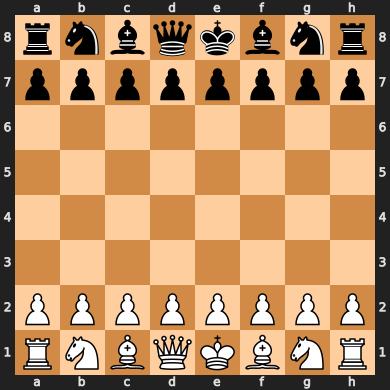

In [10]:
board

In [11]:
# make moves
board.legal_moves

<LegalMoveGenerator at 0x7da2346f5150 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>

In [12]:
legal_moves = list(board.legal_moves)
for move in legal_moves:
    print(move)

g1h3
g1f3
b1c3
b1a3
h2h3
g2g3
f2f3
e2e3
d2d3
c2c3
b2b3
a2a3
h2h4
g2g4
f2f4
e2e4
d2d4
c2c4
b2b4
a2a4


## Make move

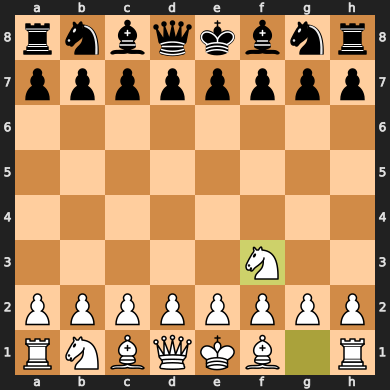

In [7]:
# create move
Nf3 = chess.Move.from_uci("g1f3")
board.push(Nf3)
board

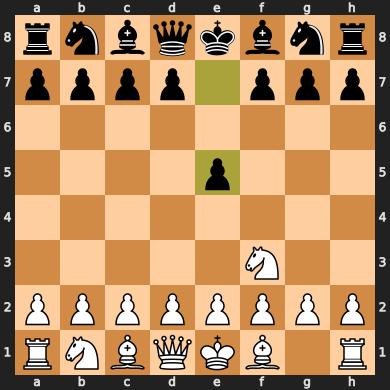

In [8]:
Pe5 = chess.Move.from_uci("e7e5")
board.push(Pe5)
board

# Evaluate board position

In [14]:
# # find chess engine
# engine = chess.engine.SimpleEngine.popen_uci('/opt/homebrew/Cellar/stockfish/17/bin/stockfish')

# # evaluate board position
# info = engine.analyse(board, limit=chess.engine.Limit(time=1))

# engine.quit()

In [10]:
info['score']

PovScore(Cp(+133), WHITE)

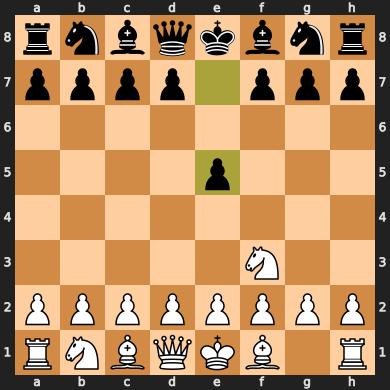

In [11]:
board

# Define reward system

In [7]:
def get_reward(board):
    """
    Calculate the reward for the current board state.
    Returns +1 for a win, -1 for a loss and 0 for a draw or ongoing game.
    """

    if board.is_checkmate():

        # win for the side who made the last move
        return 1 if board.turn==chess.BLACK else -1
    elif board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
        # stalemate, insufficient material or if 75-move rule results in a draw
        return 0
    else:
        # ongoing game, no reward yet
        return 0
    

In [8]:
def intermediate_rewards(board, move):
    """
    Calculate rewards for intermediate actions, such as capturing pieces.
    """

    if board.is_capture(move):
        ### reward for capturing an opponent's piece

        captured_piece = board.piece_at(move.to_square) # find the piece at the target square
        piece_value = get_piece_value(captured_piece) # calculate piece value
        return piece_value
    else:
        return 0
    
def get_piece_value(piece):
    """
    Returns the value of the captured piece.
    """

    if piece.piece_type == chess.PAWN:
        return 0.1
    elif piece.piece_type == chess.KNIGHT or piece.piece_type == chess.BISHOP:
        return 0.3
    elif piece.piece_type == chess.ROOK:
        return 0.5
    elif piece.piece_type == chess.QUEEN:
        return 0.9
    else:
        return 0


    

# Define RL agent

## State representation
How the agent 'sees' the chessboard.

In [9]:
# using the FEN (Forsyth-Edwards Notation) notation
board_fen = board.fen()
board_fen

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

## Action space
How the agent chooses moves from the list of legal moves

In [10]:
list(board.legal_moves)

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

In [11]:
import random

def random_move(board):
    legal_moves = list(board.legal_moves) # find all legal moves
    return random.choice(legal_moves) # randomly select a move

In [12]:
r_move = random_move(board)
r_move

Move.from_uci('h2h4')

In [13]:
board.push(r_move)

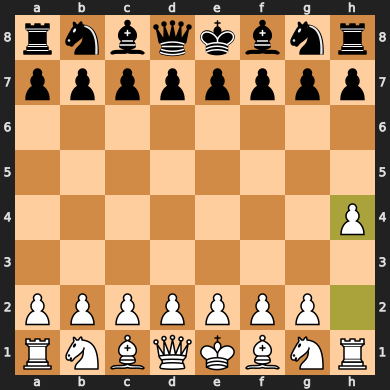

In [14]:
board

# Implement Q-learning

1. Initialise Q-table
2. Select action
3. Update-Q values

In [48]:
import numpy as np
from collections import defaultdict

In [49]:
# initialise Q-table
q_table = defaultdict(float)
q_table

defaultdict(float, {})

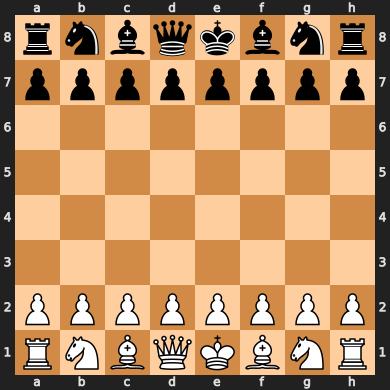

In [50]:
# initialise chess board
board = chess.Board()
board

In [51]:
# hyperparameters
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.2 # exploration rate

# choose move
def choose_action(board, epsilon):
    if random.uniform(0, 1) < epsilon: # explore
        print('EXPLORE')
        return random_move(board)
    else: # exploit - make the best possible move
        print('EXPLOIT')
        state = board.fen()
        legal_moves = list(board.legal_moves)
        q_values = [q_table[(state, move.uci())] for move in legal_moves] # find the q-values for all legal moves
        best_move = legal_moves[np.argmax(q_values)] # find the move with the highest q-value -- **multiply by chess.BLACK

        print('Q-value:', max(q_values))
        return best_move
    
# update q-table every time the agent visits a state
def update_Q_table(state, action, reward, next_state):
    """Update the Q-value for the state-action pair using the Q-learning formula"""
    print('Legal moves:', board.legal_moves)

    # what is the most reward from the next state?
    if reward!=0:
        best_next_move=0
    else:
        best_next_move = max(q_table[(next_state, move.uci())] for move in board.legal_moves) if not board.is_game_over() else 0

    # q-learning formula
    q_table[(state, action)] = q_table[(state, action)] + alpha*(reward + gamma*best_next_move - q_table[(state, action)])

    print('Updated Q-value for state {} and action {}:'.format(state, action), q_table[(state, action)])

# Q-learning training
for episode in range(30): # number of episodes
    print('-'*10, 'EPISODE:', episode, '-'*10)
    board.reset()
    while not board.is_game_over():

        state = board.fen() # get board state
        action = choose_action(board, epsilon) # make a move
        board.push(action)

        print('State:', state)
        print('Action:', action)

        next_state=board.fen() # get the next state
        reward = get_reward(board) # get reward

        print('Next state:', next_state)
        print('Reward:', reward)

        # update q-table
        update_Q_table(state, action.uci(), reward, next_state)

        # check for game over
        if board.is_game_over():
            break



---------- EPISODE: 0 ----------
EXPLOIT
Q-value: 0.0
State: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Action: g1h3
Next state: rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1
Reward: 0
Legal moves: <LegalMoveGenerator at 0x7f19d8176dd0 (Nh6, Nf6, Nc6, Na6, h6, g6, f6, e6, d6, c6, b6, a6, h5, g5, f5, e5, d5, c5, b5, a5)>
Updated Q-value for state rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 and action g1h3: 0.0
EXPLOIT
Q-value: 0.0
State: rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1
Action: g8h6
Next state: rnbqkb1r/pppppppp/7n/8/8/7N/PPPPPPPP/RNBQKB1R w KQkq - 2 2
Reward: 0
Legal moves: <LegalMoveGenerator at 0x7f19d8174760 (Ng5, Nf4, Ng1, Rg1, Nc3, Na3, g3, f3, e3, d3, c3, b3, a3, g4, f4, e4, d4, c4, b4, a4)>
Updated Q-value for state rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1 and action g8h6: 0.0
EXPLOIT
Q-value: 0.0
State: rnbqkb1r/pppppppp/7n/8/8/7N/PPPPPPPP/RNBQKB1R w KQkq - 2 2
Action: h3g5
Next state: rnbqkb1r/ppp

In [44]:
action = choose_action(board, epsilon)
action

EXPLOIT
Q-value: 0.0


Move.from_uci('g8h8')

In [54]:
board = chess.Board('7k/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 b - - 39 171')

state = board.fen() # get board state
# action = choose_action(board, epsilon) # make a move
action = chess.Move.from_uci('h8g8')
board.push(action)

print('State:', state)
print('Action:', action)

next_state=board.fen() # get the next state
reward = get_reward(board) # get reward

print('Next state:', next_state)
print('Reward:', reward)

# update q-table
update_Q_table(state, action.uci(), reward, next_state)

State: 7k/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 b - - 39 171
Action: h8g8
Next state: 6k1/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 w - - 40 172
Reward: 0
Legal moves: <LegalMoveGenerator at 0x7f19da029180 (Rc8#, Rh7, Rg7+, Rf7, Re7, Rd7, Rxb7, Rc6, Rc5, Rc4, Rc3, Rc2, Rc1, Kh6, h5, a5)>
Updated Q-value for state 7k/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 b - - 39 171 and action h8g8: 0.009000000000000001


In [ ]:
State: R4qk1/8/p5K1/P6P/3P1P2/2P1P3/6P1/8 b - - 0 142
Action: g8h8

h8g8

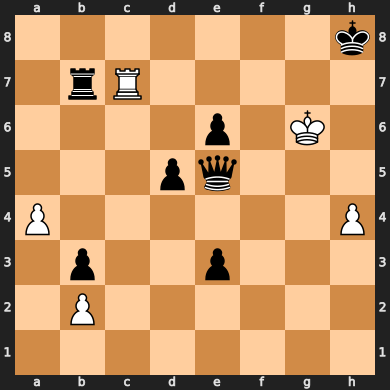

In [53]:
board_example = chess.Board('7k/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 b - - 39 171')
board_example

In [52]:
q_table[('6k1/1rR5/4p1K1/3pq3/P6P/1p2p3/1P6/8 w - - 40 172', 'c7c8')]

0.1

In [ ]:
# Assuming Q_table is a dictionary of state-action pairs with Q-values
non_zero_q_values = {state: action_values for state, action_values in q_table.items() 
                     if any(value != 0 for value in action_values.values())}

# To print non-zero Q-values
for state, action_values in non_zero_q_values.items():
    print(f"State: {state}, Action Values: {action_values}")

In [63]:
get_reward(board)

0